In [10]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import negative_sampling
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import from_networkx, to_undirected


In [11]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [12]:
# Load and combine the embeddings, ensuring all are reduced to 512 dimensions
embedding_paths = {
    'gene': '/data/luis/CellDrugNet/data/Embeddings/gene_embeddings_512.csv',
    'drug': '/data/luis/CellDrugNet/data/Embeddings/drug_embeddings_chemberta_512.csv', 
    'cell': '/data/luis/CellDrugNet/data/Embeddings/cell_embeddings_512.csv'
}

In [13]:
def load_embeddings(paths):
    all_embeddings = {}
    for entity_type, path in paths.items():
        df = pd.read_csv(path)
        for _, row in df.iterrows():
            all_embeddings[row[0]] = row[1:].astype(np.float32).values
    return all_embeddings

embeddings = load_embeddings(embedding_paths)

In [14]:
## DATASETS ##
##------------------------------GENE-TO-CELL-----------------------------------##
# Load and preprocess the gene-to-cell dataset
df_gene_cell = pd.read_csv('/data/luis/CellDrugNet/data/Datasets/genetocell.csv')  
df_gene_cell = df_gene_cell[['cell', 'gene']]

##------------------------------GENE-TO-DRUG------------------------------------##
df_gene_drug = pd.read_csv('/data/luis/CellDrugNet/data/Datasets/genetodrug.csv')  
df_gene_drug = df_gene_drug[['Gene', 'SMILES2']]
df_gene_drug.rename(columns={'SMILES2': 'SMILES'}, inplace=True)
print(df_gene_drug.head())
print(f"Number of rows: {len(df_gene_drug)}")

##------------------------------CELL-TO-DRUG-----------------------------------##

# Load the top 1% (positive edges) and bottom 50% (negative edges) cell-drug matrices
top_1_percent = pd.read_csv('/data/luis/CellDrugNet/data/Datasets/depmap_mean_top1_SMILES.csv', index_col=0)
bottom_50_percent = pd.read_csv('/data/luis/CellDrugNet/data/Datasets/depmap_mean_bottom1_SMILES.csv', index_col=0)

     Gene                                             SMILES
0    NRAS  CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCN...
1  MAP2K1  CC1=NC2=C(N1C3CCN(CC3F)C(=O)CO)C4=CC(=C(C=C4N=...
2    NRAS  CC1=CC(=C(C=C1C2=C(N=C3C(=C2)C=NC(=N3)NC)C)NC(...
3    NRAS  CC1C2=C(C=CC(=C2)F)C(=O)N(CC3=NN(C(=C3C4=CC(=C...
4    NRAS  COC1=C(C=C(C=N1)C2=CC3=C(C=CN=C3C=C2)C4=CN=NC=...
Number of rows: 6177


In [15]:
## PPI DATA ##
ppi_data = pd.read_csv('/data/luis/CellDrugNet/data/Datasets/gene_gene_association.csv')

In [16]:
# Extract unique nodes
genes = np.unique(np.concatenate([df_gene_cell['gene'], df_gene_drug['Gene']]))
cells = np.unique(np.concatenate([df_gene_cell['cell'], top_1_percent.index]))
drugs = np.unique(np.concatenate([df_gene_drug['SMILES'], top_1_percent.columns]))

## CHECK IF THERE ARE ANY OTHER GENE NODES WITH EMBEDDINGS THAT MAY BE INCLUDED IN PPI DATA ## HETGNN
ppi_genes = set(ppi_data['Gene1']).union(set(ppi_data['Gene2']))
all_genes = set(df_gene_cell['gene']).union(set(df_gene_drug['Gene'])).union(ppi_genes)

genes = np.array(list(all_genes))

print("Length genes:", len(genes))
print("Length cells:", len(cells))
print("Length drugs:", len(drugs))

## MAPPINGS ##
gene2idx = {gene: i for i, gene in enumerate(genes)} # Ex: genes = ['geneA', 'geneB', 'geneC'], gene2idx = {'geneA': 0, 'geneB': 1, 'geneC': 2}
cell2idx = {cell: i + len(genes) for i, cell in enumerate(cells)} # Ex. cells = ['cellX', 'cellY'], cell2idx = {'cellX': 3, 'cellY': 4}
drug2idx = {drug: i + len(genes) + len(cells) for i, drug in enumerate(drugs)} # Ex. drugs = ['drug1', 'drug2'], drug2idx = {'drug1': 5, 'drug2': 6}

Length genes: 19978
Length cells: 1762
Length drugs: 3175


In [17]:
num_nodes = len(genes) + len(cells) + len(drugs)
embedding_dim = 512
node_features = torch.zeros((num_nodes, embedding_dim), dtype=torch.float32)

In [18]:
# Fill in the node features with the pre-trained embeddings
num_genes = 0
num_cells = 0
num_drugs = 0

for gene in genes:
    if gene in embeddings:
        node_features[gene2idx[gene]] = torch.tensor(embeddings[gene], dtype=torch.float32)
        num_genes += 1
for cell in cells:
    if cell in embeddings:
        node_features[cell2idx[cell]] = torch.tensor(embeddings[cell], dtype=torch.float32)
        num_cells += 1
for drug in drugs:
    if drug in embeddings:
        node_features[drug2idx[drug]] = torch.tensor(embeddings[drug], dtype=torch.float32)
        num_drugs += 1

print(f"Number of genes in embeddings: {num_genes}")
print(f"Number of cells in embeddings: {num_cells}")
print(f"Number of drugs in embeddings: {num_drugs}")

Number of genes in embeddings: 14300
Number of cells in embeddings: 998
Number of drugs in embeddings: 2061


In [ ]:
# Generate edges
edges = []

# Add gene-to-cell edges
for _, row in df_gene_cell.iterrows():
    gene_idx = gene2idx[row['gene']]
    cell_idx = cell2idx[row['cell']]
    edges.append([gene_idx, cell_idx])

# Add gene-to-drug edges
for _, row in df_gene_drug.iterrows():
    gene_idx = gene2idx[row['Gene']]
    drug_idx = drug2idx[row['SMILES']]
    edges.append([gene_idx, drug_idx])

# Add PPI edges
G = nx.Graph()
for _, row in ppi_data.iterrows():
    if row['Gene1'] in gene2idx and row['Gene2'] in gene2idx:
        gene1_idx = gene2idx[row['Gene1']]
        gene2_idx = gene2idx[row['Gene2']]
        G.add_edge(gene1_idx, gene2_idx)
ppi_edges = from_networkx(G).edge_index.cpu().numpy().T.tolist()
edges.extend(ppi_edges)

print(edges)

In [89]:
# Add cell-to-drug edges from top 1% (positive edges)
positive_edges = []
for cell in top_1_percent.index:
    for drug in top_1_percent.columns:
        # Check if cell and drug exist in the DataFrame and extract value
        if cell in top_1_percent.index and drug in top_1_percent.columns:
            value = top_1_percent.loc[cell, drug]
            if isinstance(value, (int, float, str)) and pd.notna(value):  # Check for scalar value and non-NaN
                cell_idx = cell2idx[cell]
                drug_idx = drug2idx[drug]
                positive_edges.append([cell_idx, drug_idx])

# Add cell-to-drug edges from bottom 50% (negative edges)
negative_edges = []
for cell in bottom_50_percent.index:
    for drug in bottom_50_percent.columns:
        # Check if cell and drug exist in the DataFrame and extract value
        if cell in bottom_50_percent.index and drug in bottom_50_percent.columns:
            value = bottom_50_percent.loc[cell, drug]
            if isinstance(value, (int, float, str)) and pd.notna(value):  # Check for scalar value and non-NaN
                cell_idx = cell2idx[cell]
                drug_idx = drug2idx[drug]
                negative_edges.append([cell_idx, drug_idx])

# Combine positive edges with other edges
edges.extend(positive_edges)

# Convert edges to PyTorch tensors
edges = torch.tensor(edges, dtype=torch.long).t().contiguous().to(device)

# Prepare positive and negative edge sets
positive_edges = torch.tensor(positive_edges, dtype=torch.long).t().to(device)
negative_edges = torch.tensor(negative_edges, dtype=torch.long).t().to(device)

# Split positive edges into training and testing sets
train_pos_edges, test_pos_edges = train_test_split(
    positive_edges.t().cpu().numpy(), test_size=0.3, random_state=1234
)

train_pos_edges = torch.tensor(train_pos_edges, dtype=torch.long).t().to(device)
test_pos_edges = torch.tensor(test_pos_edges, dtype=torch.long).t().to(device)

# Prepare training edge index
train_edge_index = torch.cat([edges, train_pos_edges], dim=1).to(device)

# Prepare PyTorch Geometric data objects
train_data = Data(x=node_features, edge_index=train_edge_index).to(device)
test_data = Data(x=node_features, edge_index=test_pos_edges).to(device)

print("Positive edges (train):", train_pos_edges.size(1))
print("Positive edges (test):", test_pos_edges.size(1))
print("Negative edges:", negative_edges.size(1))

Positive edges (train): 9518
Positive edges (test): 2380
Negative edges: 11782


In [90]:
# ## Add PPI Edges ##
# G = nx.Graph()

# for _, row in ppi_data.iterrows():
#     if row['Gene1'] in gene2idx and row['Gene2'] in gene2idx:
#         gene1_idx = gene2idx[row['Gene1']]
#         gene2_idx = gene2idx[row['Gene2']]
#         G.add_edge(gene1_idx, gene2_idx)

# # Add all nodes that are in gene2idx to the graph to avoid missing nodes (undirected convention)
# G.add_nodes_from(gene2idx.values())

# # Convert the NetworkX graph to PyTorch Geometric format
# edge_index = from_networkx(G).edge_index

# # Ensure edges are undirected
# edge_index = to_undirected(edge_index)

# # Convert edge_index back to numpy and extend the edges list
# ppi_edges = edge_index.cpu().numpy().T
# edges = edges.tolist()
# edges.extend(ppi_edges.tolist())

# # Convert edges to torch format
# edges = torch.tensor(edges, dtype=torch.long).t().contiguous().to(device)


In [91]:
# ## Divide up specific edges: cell - drug edges and all other edges ##

# cell_indices_set = set(cell2idx.values())
# drug_indices_set = set(drug2idx.values())

# cell_drug_edges = []
# other_edges = []

# for i in range(edges.size(1)):
#     src, dst = edges[0, i].item(), edges[1, i].item()
#     if (src in cell_indices_set and dst in drug_indices_set) or (src in drug_indices_set and dst in cell_indices_set):
#         cell_drug_edges.append([src, dst])
#     else:
#         other_edges.append([src, dst])

# print("cell drug edges: ", len(cell_drug_edges))
# print("all other edges: ", len(other_edges))

# ## Convert edge lists in tensors ##
# cell_drug_edges = torch.tensor(cell_drug_edges, dtype=torch.long).t().to(device)
# other_edges = torch.tensor(other_edges, dtype=torch.long).t().to(device)

In [92]:
# ## Split edges into Training and Testing Sets ##

# train_cell_drug_edges, test_cell_drug_edges = train_test_split(cell_drug_edges.t().cpu().numpy(), test_size=0.2, random_state=1234) 

# # Convert back to PyTorch Tensors
# train_cell_drug_edges = torch.tensor(train_cell_drug_edges, dtype=torch.long).t().to(device)
# print("Train cell drug edges size: ", train_cell_drug_edges.size(1))
# test_cell_drug_edges = torch.tensor(test_cell_drug_edges, dtype=torch.long).t().to(device)
# print("Test cell drug edges size: ", test_cell_drug_edges.size(1))


In [93]:
# ## Clone the original edges index for reference ##
# original_edge_index = edges.clone().to(device)

In [94]:
# ## Remove the edges in cell_drug_edge_index for training ##
# '''
# 'edges.size(1)': retreives the size of the second dimension [2, num_edges] = num_edges and creates a 1D tensor filled with ones with len(num_edges)
# 'dtype=torch.bool': sets all 1s = True, so each element in tensor will be 'True'.
# 'device=edge_index.device': ensures the 'mask' tensor is created on the same device as 'edge_index'
# '''
# mask = torch.ones(edges.size(1), dtype=torch.bool, device=edges.device)

# for i in range(cell_drug_edges.size(1)): # iterating over each 'cell_drug_edge', size 'cell_drug_edge.size(1)'
#     '''
#     'edges[0] == cell_drug_edges[0, i]' check source node of any edge in 'edge_index' matches source node in 'cell_drug_edge'
#     'edges[1] == cell_drug_edges[1, i]' checks if target node of any edge in 'edge_index' matches target node in 'cell_drug_edge'
#     '''
#     match = (edges[0] == cell_drug_edges[0, i]) & (edges[1] == cell_drug_edges[1, i])
#     mask = mask & ~match # Updates 'mask' by setting elements to 'False' where there is a match between an edge in 'edge_index' and the current 'cell_drug_edge'
#     # This EXCLUDES these matching edges from further processing
    
# # This includes all edges EXCEPT those edges that match in 'edge_index' and 'cell_drug_index' that aren't already in 'train_cell_drug_edges'
# train_edge_index = torch.cat([original_edge_index[:, mask], train_cell_drug_edges], dim=1).to(device)
# print(train_edge_index.shape)
# print("Shape of train_edge_index: ", train_edge_index.size(1))

In [95]:
# ## Prepare the Data Objects ##
# train_data_cd = Data(x=node_features, edge_index=train_cell_drug_edges).to(device) 
# train_data = Data(x=node_features, edge_index=train_edge_index).to(device) 
# test_data = Data(x=node_features, edge_index=test_cell_drug_edges).to(device) 


# # print("train_data_cd size: ", train_data_cd.size(1))
# # print("Number of edges in train_data_cd: ", train_data_cd.edge_index.size(1))
# # print("train_data size: ", train_data.size(1))
# # print("Number of edges in train_data: ", train_data.edge_index.size(1))
# # print("Number of edges in test_data: ", test_data.edge_index.size(1))

In [96]:
# ## Positive and Negative samples for cell - drug edges ##
# def generate_cell_drug_edge_samples_with_split(cell_nodes, drug_nodes, train_pos_edge_index, test_pos_edge_index, num_neg_samples):
#     # Generate all possible edges between the given 'cell_nodes' and 'drug_nodes'. Results in every possible pair of cell and drug nodes.
#     all_possible_edges = torch.cartesian_prod(cell_nodes, drug_nodes)

#     # Convert existing positive edges to a set 
#     train_pos_edges_set = set(map(tuple, train_pos_edge_index.t().tolist()))
#     test_pos_edges_set = set(map(tuple, test_pos_edge_index.t().tolist()))

#     # Combine both sets to exclude any edges that is in either the training or testing positive edge sets
#     all_pos_edges_set = test_pos_edges_set.union(train_pos_edges_set)

#     # Filter out positive edges to get candidate negative edges
#     candidate_neg_edges = [tuple(edge.tolist()) for edge in all_possible_edges if tuple(edge.tolist()) not in all_pos_edges_set]
    
#     if len(candidate_neg_edges) < num_neg_samples:
#         print(f"Warning: Only {len(candidate_neg_edges)} negative samples available, fewer than requested {num_neg_samples}.")
#         num_neg_samples = len(candidate_neg_edges)

#     # Randomly select a number of negative samples, from remaining 'candidate_neg_edges', equal to num_neg_samples
#     neg_edge_index = torch.tensor(candidate_neg_edges, dtype=torch.long).T
#     neg_edge_index = neg_edge_index[:, torch.randperm(neg_edge_index.size(1))[:num_neg_samples]]

#     # Split the negative edges into training and testing sets
#     split_idx = int(0.8 * num_neg_samples) # Calculate the split index
#     neg_train_edge_index = neg_edge_index[:, :split_idx] # Split the negative edges into training set, first 80%
#     neg_test_edge_index = neg_edge_index[:, split_idx:] # Split the negative edges into testing set, last 20%


#     return neg_train_edge_index, neg_test_edge_index

In [97]:
# ## train cd negative edges ##
# ## Preparing cell and drug nodes for intput into generate_cell_drug_edge_samples() ##
# cell_nodes = torch.tensor(list(cell2idx.values()), dtype=torch.long).to(device)
# drugs_nodes = torch.tensor(list(drug2idx.values()), dtype=torch.long).to(device)

# num_train_pos_edges = train_data_cd.edge_index.size(1)
# num_test_pos_edges = test_data.edge_index.size(1)

# # Total number of positive edges
# total_num_pos_edges = num_train_pos_edges + num_test_pos_edges

# train_cd_neg_edge, cell_drug_neg_edges = generate_cell_drug_edge_samples_with_split(cell_nodes, drugs_nodes, train_data_cd.edge_index, test_data.edge_index, total_num_pos_edges)

# print("train_cd_neg_edge size: ", train_cd_neg_edge.size(1))
# print("test size: ", cell_drug_neg_edges.size(1))

In [98]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(embedding_dim, 128)
        self.conv2 = GCNConv(128, 64)
        self.conv3 = GCNConv(64, 64)
        self.leaky_relu = torch.nn.LeakyReLU(negative_slope=0.2)  

    def forward(self, x, edge_index):
        # convolution layer 1
        x = self.conv1(x, edge_index)
        x = self.leaky_relu(x)
        x = F.dropout(x, p=0.3, training=self.training)

        # convolution layer 2
        x = self.conv2(x, edge_index)
        x = self.leaky_relu(x)
        x = F.dropout(x, p=0.3, training=self.training)

        # convolution layer 3
        x = self.conv3(x, edge_index)
        return x
    
    def decode(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1) #Remove sum function. Take edge index before dot product and use as feature for cell-drug pair. Show U map to see differences between positive and negative edges. 

        return logits

In [99]:
model = GCN().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss()
sigmoid = torch.nn.Sigmoid()
train_losses = []

def train():
    model.train()
    optimizer.zero_grad()
    z = model(train_data.x, train_data.edge_index) 
    
    pos_samples = train_pos_edges  # Use the updated positive edges
    neg_samples = negative_edges  # Use the updated negative edges
    labels = torch.cat([torch.ones(pos_samples.size(1)), torch.zeros(neg_samples.size(1))]).to(device)
    
    logits = model.decode(z, pos_samples, neg_samples).to(device)
                        
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    
    return loss.item()

In [ ]:
# Training Loop
patience = 20
patience_counter = 0
best_train_loss = float('inf')

for epoch in range(1, 10001):
    loss = train()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')
        
        if loss < best_train_loss:
            best_train_loss = loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f'Early stopping: Training loss has not improved for the last {patience} epochs.')
            break

Epoch 10, Loss: 0.7017
Epoch 20, Loss: 0.6979
Epoch 30, Loss: 0.6709
Epoch 40, Loss: 0.6673
Epoch 50, Loss: 0.6584
Epoch 60, Loss: 0.6525
Epoch 70, Loss: 0.6387
Epoch 80, Loss: 0.6363
Epoch 90, Loss: 0.6337
Epoch 100, Loss: 0.6289
Epoch 110, Loss: 0.6271
Epoch 120, Loss: 0.6258
Epoch 130, Loss: 0.6217
Epoch 140, Loss: 0.6145
Epoch 150, Loss: 0.6053
Epoch 160, Loss: 0.5995
Epoch 170, Loss: 0.6007
Epoch 180, Loss: 0.5859
Epoch 190, Loss: 0.5943
Epoch 200, Loss: 0.5730
Epoch 210, Loss: 0.5849
Epoch 220, Loss: 0.5744
Epoch 230, Loss: 0.5633
Epoch 240, Loss: 0.5499
Epoch 250, Loss: 0.5353
Epoch 260, Loss: 0.5311
Epoch 270, Loss: 0.5275
Epoch 280, Loss: 0.5279
Epoch 290, Loss: 0.5232
Epoch 300, Loss: 0.5152
Epoch 310, Loss: 0.5132
Epoch 320, Loss: 0.5248
Epoch 330, Loss: 0.4941
Epoch 340, Loss: 0.5091
Epoch 350, Loss: 0.4901
Epoch 360, Loss: 0.5599
Epoch 370, Loss: 0.5878
Epoch 380, Loss: 0.5714
Epoch 390, Loss: 0.5311
Epoch 400, Loss: 0.5094
Epoch 410, Loss: 0.4927
Epoch 420, Loss: 0.5002
E

In [101]:
## INCLUDES ALL EDGES (drug, cell, gene nodes) ##

def eval_specific_edges(model, pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model(test_data.x, train_data.edge_index)
        logits = model.decode(z, pos_edge_index, neg_edge_index)

    pos_pred = logits[:pos_edge_index.size(1)]
    neg_pred = logits[pos_edge_index.size(1):]

    pos_label = torch.ones(pos_edge_index.size(1), device=device)
    neg_label = torch.zeros(neg_edge_index.size(1), device=device)

    label = torch.cat([pos_label, neg_label]).cpu()
    pred = torch.cat([torch.sigmoid(pos_pred), torch.sigmoid(neg_pred)]).cpu()

    accuracy = accuracy_score(label, (pred > 0.5).int())
    roc_auc = roc_auc_score(label, pred)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'AUC: {roc_auc:.4f}')


    # Plot ROC curve
    fpr, tpr, _ = roc_curve(label, pred)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return accuracy, roc_auc

Accuracy: 0.8408
AUC: 0.8621


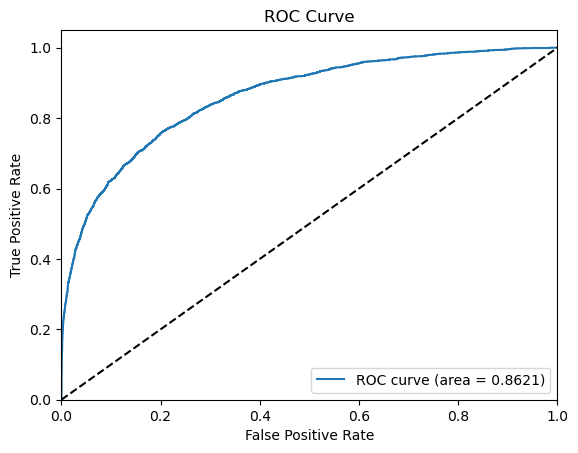

Test AUC: (0.8407710775314221, 0.8620741082037976)


In [102]:
# Evaluate the model on the test set
test_auc = eval_specific_edges(model, test_data.edge_index.to(device), negative_edges)

print(f"Test AUC: {test_auc}")